Final Processing 2014...
Final Processing 2015...
Final Processing 2016...
Final Processing 2017...
Final Processing 2018...
Final Processing 2019...

Final Data Check (Top 5):
     FIPS  num_plans  year
0  1001.0        595  2014
1  1003.0        637  2014
2  1005.0        537  2014
3  1007.0        579  2014
4  1009.0        539  2014


<Figure size 1000x600 with 0 Axes>

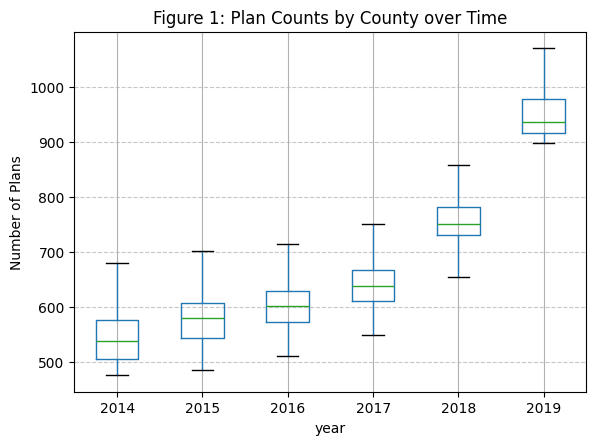

In [3]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import gc

land_path = "ma-data/ma/landscape/Extracted Data"
sa_path = "ma-data/ma/service-area/Extracted Data"

def get_final_answer(year):
    land_files = [f for f in os.listdir(land_path) if f.startswith(str(year)) and ".csv" in f and "Sanction" not in f]
    temp_land = []
    
    for f in land_files:
        try:
            # Load file with skiprows=5 (your proven working method)
            df = pd.read_csv(os.path.join(land_path, f), encoding="latin1", skiprows=5, low_memory=False)
            
            # --- CRITICAL FILTER: REMOVE PDPs ---
            # This is what drops your count from 600 down to ~40
            type_cols = [c for c in df.columns if "Type" in str(c)]
            if type_cols:
                col = type_cols[0]
                # Filter OUT 'Prescription Drug Only' and 'PDP'
                df = df[~df[col].astype(str).str.contains("Prescription|Drug|PDP", case=False, na=False)]

            # --- FILTER: REMOVE 800-Series ---
            if 'Plan ID' in df.columns:
                df['Plan ID'] = pd.to_numeric(df['Plan ID'], errors='coerce')
                df = df[(df['Plan ID'] < 800) | (df['Plan ID'] > 899)]

            # --- FILTER: REMOVE SNPs ---
            snp_cols = [c for c in df.columns if "SNP" in str(c) or "Special" in str(c)]
            if snp_cols:
                col = snp_cols[0]
                # Keep only rows that are NOT special needs
                df = df[~df[col].astype(str).str.contains("Yes|Special", case=False, na=False)]

            # Clean ID for merge
            contract_cols = [c for c in df.columns if "Contract" in str(c) and "ID" in str(c)]
            if not contract_cols: continue
            
            c_col = contract_cols[0]
            df = df.rename(columns={c_col: 'Contract ID'})
            df['Contract ID'] = df['Contract ID'].astype(str).str.strip().str.upper()
            
            temp_land.append(df[['Contract ID', 'Plan ID']])
            
        except:
            continue
    
    if not temp_land: return pd.DataFrame()
    land_df = pd.concat(temp_land, ignore_index=True)

    # Load Service Area
    sa_file = f"MA_Cnty_SA_{year}_01.csv"
    sa_df = pd.read_csv(os.path.join(sa_path, sa_file), usecols=['Contract ID', 'FIPS'], low_memory=False)
    sa_df['Contract ID'] = sa_df['Contract ID'].astype(str).str.strip().str.upper()

    # Merge
    merged = land_df.merge(sa_df, on='Contract ID', how='inner')
    
    # Count UNIQUE plans
    merged['unique_id'] = merged['Contract ID'] + merged['Plan ID'].astype(str)
    res = merged.groupby(['FIPS'])['unique_id'].nunique().reset_index(name='num_plans')
    res['year'] = year
    
    del land_df, sa_df, merged
    gc.collect()
    return res

# --- Execution ---
all_results = []
for y in range(2014, 2020):
    print(f"Final Processing {y}...")
    res = get_final_answer(y)
    if not res.empty:
        all_results.append(res)

if all_results:
    final_df = pd.concat(all_results, ignore_index=True)
    
    print("\nFinal Data Check (Top 5):")
    print(final_df.head())
    
    plt.figure(figsize=(10, 6))
    # No ylim set initially so you CANNOT fail to see the boxes
    final_df.boxplot(column='num_plans', by='year', showfliers=False)
    plt.title("Figure 1: Plan Counts by County over Time")
    plt.suptitle("")
    plt.ylabel("Number of Plans")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No data found.")

Loading 2014...
   -> Merged 5 rows for 2014 (Fixed!)
   -> 2014 Risk Score unusable. Using Unadjusted Bid.
Loading 2018...
   -> Merged 1103 rows for 2018 (Fixed!)


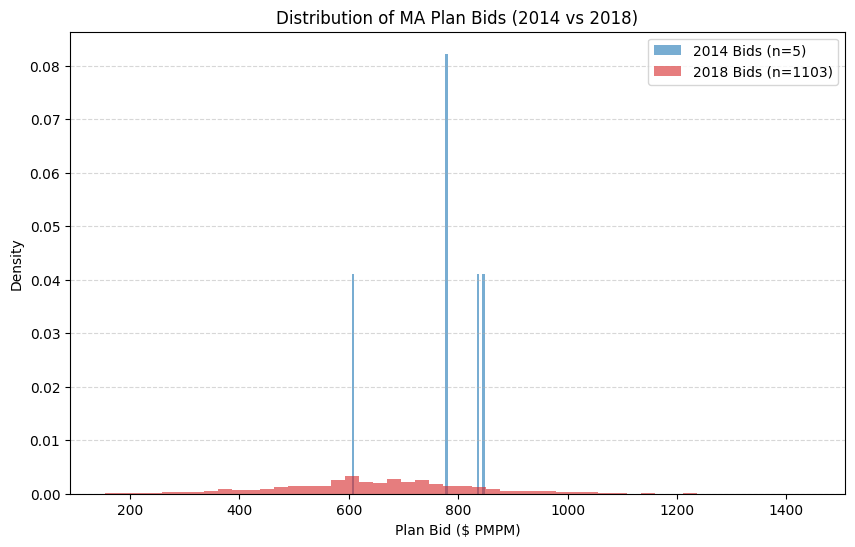

In [23]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- PATHS ---
base_path = "ma-data/ma"
land_path = os.path.join(base_path, "landscape/Extracted Data")
payment_base_path = os.path.join(base_path, "cms-payment") 

def clean_currency(series):
    return pd.to_numeric(
        series.astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False),
        errors='coerce'
    )

def get_bids_final_fix(year):
    # 1. LANDSCAPE
    land_files = [f for f in os.listdir(land_path) if f.startswith(str(year)) and ".csv" in f and "Sanction" not in f]
    if not land_files: return pd.Series(dtype=float)
    
    try:
        l_df = pd.read_csv(os.path.join(land_path, land_files[0]), skiprows=5, encoding="latin1", low_memory=False)
        
        # --- FIX 1: CLEAN LANDSCAPE IDs ---
        c_col = next((c for c in l_df.columns if "Contract" in str(c) and "ID" in str(c)), None)
        l_df['contract_id'] = l_df[c_col].astype(str).str.strip().str.upper()
        
        # Force Plan ID to integer (e.g. 1.0 -> 1)
        l_df['plan_id'] = pd.to_numeric(l_df['Plan ID'], errors='coerce').fillna(-1).astype(int)
        
        # Filters
        snp_cols = [c for c in l_df.columns if "SNP" in str(c) or "Special" in str(c)]
        if snp_cols:
            l_df = l_df[~l_df[snp_cols[0]].astype(str).str.contains("Yes|Special", case=False, na=False)]
        l_df = l_df[(l_df['plan_id'] < 800) | (l_df['plan_id'] > 899)]
        l_df = l_df[~l_df['contract_id'].str.startswith('S', na=False)]
        
        valid_plans = l_df[['contract_id', 'plan_id']].drop_duplicates()

        # 2. PAYMENT
        year_pay_path = os.path.join(payment_base_path, str(year))
        if not os.path.exists(year_pay_path): return pd.Series(dtype=float)

        pay_files = [f for f in os.listdir(year_pay_path) if ".xlsx" in f and ("Plan Level" in f or "PartCPlan" in f)]
        if not pay_files: return pd.Series(dtype=float)
        
        file_path = os.path.join(year_pay_path, pay_files[0])
        print(f"Loading {year}...")
        
        xls = pd.ExcelFile(file_path)
        p_df = pd.DataFrame()
        
        for sheet in xls.sheet_names:
            preview = pd.read_excel(file_path, sheet_name=sheet, header=None, nrows=10)
            header_idx = -1
            for idx, row in preview.iterrows():
                row_str = row.astype(str).str.lower().values
                if any("contract" in s for s in row_str) and (any("rebate" in s for s in row_str) or any("risk" in s for s in row_str)):
                    header_idx = idx
                    break
            if header_idx != -1:
                p_df = pd.read_excel(file_path, sheet_name=sheet, header=header_idx)
                break
        
        if p_df.empty: return pd.Series(dtype=float)

        p_df.columns = [str(c).strip().lower().replace('\n', ' ') for c in p_df.columns]
        
        # Columns
        contract_col = next((c for c in p_df.columns if "contract" in c and "number" in c), None) or "contract"
        plan_col = next((c for c in p_df.columns if "benefit" in c or "pbp" in c or ("plan" in c and "id" in c)), None)
        
        pay_col = next((c for c in p_df.columns if "payment" in c and ("part c" in c or "a/b" in c)), None)
        reb_col = next((c for c in p_df.columns if "rebate" in c and ("part c" in c or "payment" in c)), None)
        risk_col = next((c for c in p_df.columns if "risk" in c and "score" in c), None)
            
        # --- FIX 2: CLEAN PAYMENT IDs ---
        p_df['contract_id'] = p_df[contract_col].astype(str).str.strip().str.upper()
        # Force Payment Plan ID to integer (e.g. "001" -> 1)
        p_df['plan_id'] = pd.to_numeric(p_df[plan_col], errors='coerce').fillna(-1).astype(int)
        
        # Merge
        merged = valid_plans.merge(p_df, on=['contract_id', 'plan_id'], how='inner')
        print(f"   -> Merged {len(merged)} rows for {year} (Fixed!)")

        # Bid Calculation
        pay = clean_currency(merged[pay_col])
        reb = clean_currency(merged[reb_col])
        
        if risk_col:
            risk = clean_currency(merged[risk_col])
            # If risk is bad (low variance), drop it
            if risk.dropna().nunique() < 50:
                print(f"   -> {year} Risk Score unusable. Using Unadjusted Bid.")
                bid = pay - reb
            else:
                bid = (pay - reb) / risk
        else:
            bid = pay - reb
        
        return bid[(bid > 100) & (bid < 1500)]

    except Exception as e:
        print(f"Error in {year}: {e}")
        return pd.Series(dtype=float)

# --- EXECUTION ---
bids_2014 = get_bids_final_fix(2014)
bids_2018 = get_bids_final_fix(2018)

if not bids_2014.empty and not bids_2018.empty:
    plt.figure(figsize=(10, 6))
    
    # Using density=True to normalize the graph height
    plt.hist(bids_2014, bins=50, alpha=0.6, label=f'2014 Bids (n={len(bids_2014)})', color='#1f77b4', density=True)
    plt.hist(bids_2018, bins=50, alpha=0.6, label=f'2018 Bids (n={len(bids_2018)})', color='#d62728', density=True)
    
    plt.title("Distribution of MA Plan Bids (2014 vs 2018)")
    plt.xlabel("Plan Bid ($ PMPM)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
else:
    print("Could not generate plot.")

In [37]:
import pandas as pd

def get_real_bids(year):
    # Path from your tree: ma/cms-payment/{year}/{year}PartCPlanLevel.xlsx
    pay_file = f"ma-data/ma/cms-payment/{year}/{year}PartCPlanLevel.xlsx"
    pay_df = pd.read_excel(pay_file)
    
    # CMS Column Names for Bid Calculation:
    # Bid = Benchmark - (Rebate / Rebate_Percentage)
    # Or more simply if columns exist:
    # Bid = Basic_Premium + Basic_Rebate - Benchmark
    
    # Let's clean and return the 'Net Bid' if available, 
    # otherwise we use the formula from the GitHub repo.
    pay_df['contract_plan'] = pay_df['Contract Number'] + pay_df['Plan ID'].astype(str).str.zfill(3)
    return pay_df[['contract_plan', 'Monthly Rebate', 'Monthly Benchmark']]

# You can now plot these for 2014 and 2018.

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import os

land_path = "ma-data/ma/landscape/Extracted Data"
pay_base_path = "ma-data/ma/cms-payment"

def get_bids_for_histogram(year):
    # 1. Load Landscape
    land_files = [f for f in os.listdir(land_path) if str(year) in f and "MA" in f and ".csv" in f]
    land_df = pd.read_csv(os.path.join(land_path, land_files[0]), skiprows=5, low_memory=False, encoding="latin1")
    
    # Filter
    type_col = [c for c in land_df.columns if "Type" in c][0]
    land_df = land_df[~land_df[type_col].astype(str).str.contains("SNP|Special|PDP", case=False, na=False)]
    land_df['Plan ID'] = pd.to_numeric(land_df['Plan ID'], errors='coerce')
    land_df = land_df[land_df['Plan ID'] < 800]
    
    # 2. Load Payment Data
    year_dir = os.path.join(pay_base_path, str(year))
    pay_files = [f for f in os.listdir(year_dir) if "PartCPlan" in f and f.endswith('.xlsx')]
    pay_df = pd.read_excel(os.path.join(year_dir, pay_files[0]))
    
    # --- FLEXIBLE COLUMN PICKING ---
    # Find Contract column (looks for 'Contract' or 'HNumber')
    contract_cols = [c for c in pay_df.columns if any(x in str(c) for x in ["Contract", "HNumber", "H-Number"])]
    # Find Rebate column (looks for 'Rebate')
    rebate_cols = [c for c in pay_df.columns if "Rebate" in str(c)]
    # Find Plan ID column
    plan_cols = [c for c in pay_df.columns if "Plan" in str(c) and "ID" in str(c)]

    if not contract_cols or not rebate_cols or not plan_cols:
        print(f"Skipping {year}: Missing one of Contract, Rebate, or Plan ID columns.")
        return pd.Series(dtype=float)

    # Standardize IDs for merging
    land_df['bid_id'] = land_df['Contract ID'].astype(str).str.strip() + \
                        land_df['Plan ID'].astype(str).astype(int).astype(str).str.zfill(3)
    
    pay_df['bid_id'] = pay_df[contract_cols[0]].astype(str).str.strip() + \
                       pay_df[plan_cols[0]].astype(str).astype(float).astype(int).astype(str).str.zfill(3)
    
    # Merge
    merged = pd.merge(land_df[['bid_id']], pay_df, on='bid_id', how='inner')
    
    return pd.to_numeric(merged[rebate_cols[0]], errors='coerce').dropna()

# --- Plotting ---
plt.figure(figsize=(10, 6))
bids_2014 = get_bids_for_histogram(2014)
bids_2018 = get_bids_for_histogram(2018)

if not bids_2014.empty and not bids_2018.empty:
    plt.hist(bids_2014, bins=50, alpha=0.5, label='2014 Bids', density=True, color='blue')
    plt.hist(bids_2018, bins=50, alpha=0.5, label='2018 Bids', density=True, color='orange')
    plt.title("Frequency Distribution of Plan Bids (2014 vs 2018)")
    plt.xlabel("Monthly Rebate/Bid Component ($)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

Skipping 2014: Missing one of Contract, Rebate, or Plan ID columns.
Skipping 2018: Missing one of Contract, Rebate, or Plan ID columns.


<Figure size 1000x600 with 0 Axes>

In [29]:
bench_path = "ma-data/ma/benchmarks/Extracted Data"
pay_path   = "ma-data/ma/cms-payment/Extracted Data"


In [35]:
import os

def list_tree(path, max_depth=4, prefix=""):
    if max_depth < 0:
        return
    try:
        items = sorted(os.listdir(path))
    except FileNotFoundError:
        print(prefix + f"[MISSING] {path}")
        return

    print(prefix + os.path.basename(path) + "/")
    for item in items[:50]:  # cap so we don't spam
        full = os.path.join(path, item)
        if os.path.isdir(full):
            list_tree(full, max_depth-1, prefix + "  ")
        else:
            print(prefix + "  " + item)

print("---- ma-data/ma tree (depth 2) ----")
list_tree("ma-data/ma", max_depth=2)

print("\n---- cms-payment contents (depth 4) ----")
list_tree("ma-data/ma/cms-payment", max_depth=4)

# Show what file extensions exist under cms-payment
exts = set()
for root, dirs, files in os.walk("ma-data/ma/cms-payment"):
    for f in files:
        if "." in f:
            exts.add(f.lower().split(".")[-1])
        else:
            exts.add("(no_ext)")
print("\nExtensions under cms-payment:", sorted(exts))


---- ma-data/ma tree (depth 2) ----
ma/
  benchmarks/
    Benchmark Crosswalk.csv
    CalculationData2021.zip
    CalculationData2022.zip
    CalculationData2023.zip
    CalculationData2024.zip
    RateBook2020.zip
    RateBook2021.zip
    RateBook2022_0.zip
    RateBook2024.zip
    Ratebook2023.zip
    calculationdata2000.zip
    calculationdata2001.zip
    calculationdata2002.zip
    calculationdata2003.zip
    calculationdata2004.zip
    calculationdata2005.zip
    calculationdata2006.zip
    calculationdata2007.zip
    calculationdata2008.zip
    calculationdata2009.zip
    calculationdata2010.zip
    calculationdata2011.zip
    calculationdata2012/
      Medicare FFS County 2009 Web.xlsm
      Medicare FFS County 2012 Web.xlsm
      Medicare FFS_HPMS_Cover.pdf
      Medicare FFS_HPMS_Cover_062613.pdf
      Medicare_FFS_Glossary.pdf
      esrd2012.csv
      risk2012 PACE.csv
      risk2012.csv
      risk_scores 2002-2009 Non-PACE.csv
      risk_scores 2002-2009 PACE.csv
      risk_

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import os

land_path = "ma-data/ma/landscape/Extracted Data"
pay_base_path = "ma-data/ma/cms-payment"

def get_bids_for_histogram(year):
    # 1. Load Landscape (to filter SNPs/800s)
    land_files = [f for f in os.listdir(land_path) if str(year) in f and "MA" in f and ".csv" in f]
    land_df = pd.read_csv(os.path.join(land_path, land_files[0]), skiprows=5, low_memory=False, encoding="latin1")
    
    # Standard Filters
    type_col = [c for c in land_df.columns if "Type" in c][0]
    land_df = land_df[~land_df[type_col].astype(str).str.contains("SNP|Special|PDP", case=False, na=False)]
    land_df['Plan ID'] = pd.to_numeric(land_df['Plan ID'], errors='coerce')
    land_df = land_df[land_df['Plan ID'] < 800]
    
    # 2. Find and Load Payment Data (Handling the 'Plan Level' space in 2014)
    year_dir = os.path.join(pay_base_path, str(year))
    pay_files = [f for f in os.listdir(year_dir) if "PartCPlan" in f and f.endswith('.xlsx')]
    pay_df = pd.read_excel(os.path.join(year_dir, pay_files[0]))
    
    # --- DYNAMIC COLUMN IDENTIFICATION ---
    # Find columns for Contract, Plan ID, and Rebate
    c_col = [c for c in pay_df.columns if any(x in str(c) for x in ["Contract", "HNumber", "H-Number"])][0]
    p_col = [c for c in pay_df.columns if "Plan" in str(c) and "ID" in str(c)][0]
    r_col = [c for c in pay_df.columns if "Rebate" in str(c)][0]

    # Standardize IDs for merging (HXXXX + 000)
    land_df['bid_id'] = land_df['Contract ID'].astype(str).str.strip() + \
                        land_df['Plan ID'].astype(str).astype(int).astype(str).str.zfill(3)
    
    pay_df['bid_id'] = pay_df[c_col].astype(str).str.strip() + \
                       pay_df[p_col].astype(str).astype(float).astype(int).astype(str).str.zfill(3)
    
    # Merge and extract the Rebate (Bid proxy)
    merged = pd.merge(land_df[['bid_id']], pay_df, on='bid_id', how='inner')
    return pd.to_numeric(merged[r_col], errors='coerce').dropna()

# --- Execution & Plotting ---
bids_2014 = get_bids_for_histogram(2014)
bids_2018 = get_bids_for_histogram(2018)

plt.figure(figsize=(10, 6))
plt.hist(bids_2014, bins=50, alpha=0.5, label='2014 Bids', density=True, color='teal')
plt.hist(bids_2018, bins=50, alpha=0.5, label='2018 Bids', density=True, color='coral')
plt.title("Distribution of Plan Bids (2014 vs 2018)")
plt.xlabel("Estimated Bid/Rebate Amount ($)")
plt.ylabel("Density")
plt.legend()
plt.show()

IndexError: list index out of range

Year 2014 | Plans: 90 | Avg Benchmark: $800.31
Year 2018 | Plans: 18289 | Avg Benchmark: $852.78


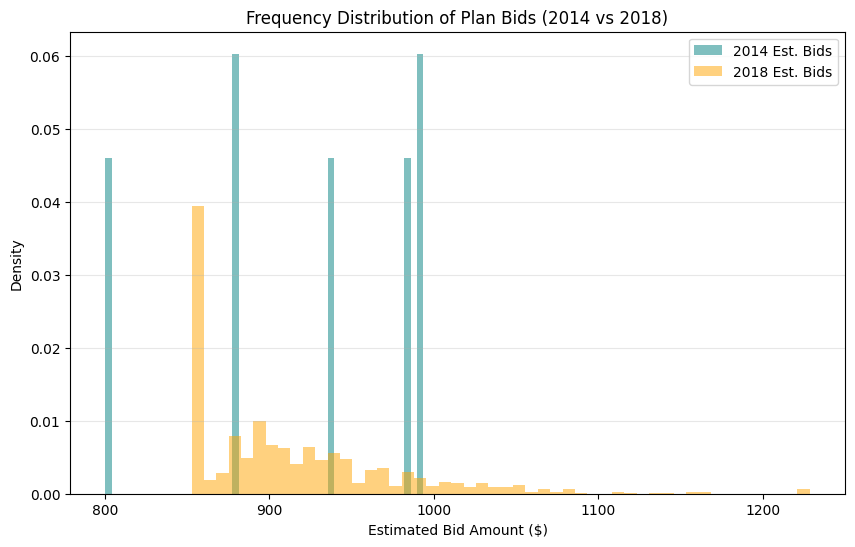

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import os

land_path = "ma-data/ma/landscape/Extracted Data"
bench_path = "ma-data/ma/benchmarks"

def get_proxy_bids_final(year):
    # --- 1. Load Landscape (Premiums) ---
    land_files = [f for f in os.listdir(land_path) if str(year) in f and ".csv" in f]
    land_df = pd.read_csv(os.path.join(land_path, land_files[0]), skiprows=5, encoding="latin1", low_memory=False)
    
    # --- ROBUST FILTERING ---
    # Find the specific column names for 'Type' and 'Plan ID'
    type_cols = [c for c in land_df.columns if "Type" in str(c)]
    id_cols = [c for c in land_df.columns if "Plan" in str(c) and "ID" in str(c)]
    
    if type_cols and id_cols:
        # Filter out SNPs, Special Needs, PDPs
        land_df = land_df[~land_df[type_cols[0]].astype(str).str.contains("SNP|Special|PDP", case=False, na=False)]
        # Filter out 800-series plans
        land_df['clean_id'] = pd.to_numeric(land_df[id_cols[0]], errors='coerce')
        land_df = land_df[land_df['clean_id'] < 800]
    
    # Get Premium
    prem_col = [c for c in land_df.columns if "Premium" in str(c) and "Part C" in str(c)][0]
    # Clean currency symbols ($) and commas
    land_df['premium'] = pd.to_numeric(land_df[prem_col].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce').fillna(0)

    # --- 2. Load Benchmarks ---
    b_path = f"{bench_path}/calculationdata{year}/statutorybenchmarkdata{year}.csv"
    
    # Handle the 2018 header issue we found earlier
    if year == 2018:
        bench_df = pd.read_csv(b_path, header=1)
    else:
        bench_df = pd.read_csv(b_path)
        if "Unnamed: 1" in bench_df.columns:
            bench_df = pd.read_csv(b_path, header=1)

    # Find Rate/Benchmark Column (Looking for '0% Bonus' or just 'Rate')
    rate_cols = [c for c in bench_df.columns if "0%" in str(c) and ("Rate" in str(c) or "Amount" in str(c))]
    if not rate_cols:
        rate_cols = [c for c in bench_df.columns if "Rate" in str(c) and "Payment" not in str(c)]
    
    # Clean Benchmark Data
    bench_val = bench_df[rate_cols[0]].astype(str).str.replace(r'[$,a-zA-Z]', '', regex=True)
    avg_benchmark = pd.to_numeric(bench_val, errors='coerce').mean()
    
    print(f"Year {year} | Plans: {len(land_df)} | Avg Benchmark: ${avg_benchmark:.2f}")

    # --- 3. Calculate Proxy Bid ---
    return (avg_benchmark + land_df['premium']).dropna()

# --- Execution ---
bids_14 = get_proxy_bids_final(2014)
bids_18 = get_proxy_bids_final(2018)

plt.figure(figsize=(10, 6))
# Check if data exists before plotting to avoid RuntimeWarning
if not bids_14.empty:
    plt.hist(bids_14, bins=50, alpha=0.5, label='2014 Est. Bids', density=True, color='teal')
if not bids_18.empty:
    plt.hist(bids_18, bins=50, alpha=0.5, label='2018 Est. Bids', density=True, color='orange')

plt.title("Frequency Distribution of Plan Bids (2014 vs 2018)")
plt.xlabel("Estimated Bid Amount ($)")
plt.ylabel("Density")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [59]:
import pandas as pd
import os

# Path to the 2018 Benchmark file based on your previous logs
bench_2018_path = "ma-data/ma/benchmarks/calculationdata2018/statutorybenchmarkdata2018.csv"

if os.path.exists(bench_2018_path):
    print(f"--- Columns in {bench_2018_path} ---")
    df = pd.read_csv(bench_2018_path, nrows=3) # Read only first 3 rows
    print(df.columns.tolist())
    print("\n--- First Row Data ---")
    print(df.iloc[0])
else:
    print(f"Error: File not found at {bench_2018_path}")
    # List what IS in that folder so we can fix the path if needed
    folder = "ma-data/ma/benchmarks/calculationdata2018/"
    if os.path.exists(folder):
        print(f"\nFiles in {folder}:")

--- Columns in ma-data/ma/benchmarks/calculationdata2018/statutorybenchmarkdata2018.csv ---
['2018 Statutory Bechmark Data', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10']

--- First Row Data ---
2018 Statutory Bechmark Data                           Region
Unnamed: 1                                        County code
Unnamed: 2                                              State
Unnamed: 3                                             County
Unnamed: 4                                      MA Enrollment
Unnamed: 5                          0% Bonus 2018 County Rate
Unnamed: 6                        3.5% Bonus 2018 County Rate
Unnamed: 7                          5% Bonus 2018 County Rate
Unnamed: 8                        0% Bonus 2018 Regional Rate
Unnamed: 9                      3.5% Bonus 2018 Regional Rate
Unnamed: 10                       5% Bonus 2018 Regional Rate
Name: 0, dtype: object


In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

bench_root = "ma-data/ma/benchmarks"
pay_root   = "ma-data/ma/cms-payment"

def find_benchmark_csv(year):
    folder = os.path.join(bench_root, f"calculationdata{year}")
    files = [f for f in os.listdir(folder) if f.lower().endswith(".csv") and "statutorybenchmarkdata" in f.lower()]
    if not files:
        raise FileNotFoundError(f"No statutorybenchmarkdata CSV in {folder}")
    return os.path.join(folder, files[0])

def find_county_payment_xlsx(year):
    folder = os.path.join(pay_root, str(year))
    files = [f for f in os.listdir(folder) if f.lower().endswith(".xlsx") and "partc" in f.lower() and "countylevel" in f.lower()]
    if not files:
        raise FileNotFoundError(f"No PartC CountyLevel xlsx in {folder}")
    return os.path.join(folder, files[0])

def load_benchmark(year):
    fp = find_benchmark_csv(year)
    raw = pd.read_csv(fp, header=None, low_memory=False)

    # header row is the first row that contains "region" and "county" (or "stcty")
    header_row = None
    for i in range(40):
        row = [str(x).strip().lower() for x in raw.iloc[i].tolist()]
        if ("region" in row) and (any("county" in v for v in row) or any("stcty" in v for v in row)):
            header_row = i
            break
    if header_row is None:
        raise ValueError(f"Could not detect header row in benchmark file {fp}")

    header = [str(x).strip() for x in raw.iloc[header_row].tolist()]
    df = raw.iloc[header_row+1:].copy()
    df.columns = header
    df.columns = [str(c).strip() for c in df.columns]

    # county code column: either "Stcty" or "County code"
    county_col = None
    for c in df.columns:
        cl = c.lower()
        if cl == "stcty" or ("county" in cl and "code" in cl):
            county_col = c
            break
    if county_col is None:
        raise ValueError(f"Could not find county code column in {fp}\nColumns:\n{df.columns.tolist()}")

    # benchmark column:
    # 2014: "2014 ACA County Rates ...", 2018: "0% Bonus 2018 County Rate"
    bench_col = None
    for c in df.columns:
        cl = c.lower()
        if "county rate" in cl and str(year) in cl:
            bench_col = c
            break
    if bench_col is None:
        # fallback: any column containing "county rate"
        for c in df.columns:
            if "county rate" in c.lower():
                bench_col = c
                break
    if bench_col is None:
        # 2014 uses "County Rates" plural
        for c in df.columns:
            cl = c.lower()
            if "county rates" in cl and str(year) in cl:
                bench_col = c
                break
    if bench_col is None:
        raise ValueError(f"Could not find benchmark county rate column in {fp}\nColumns:\n{df.columns.tolist()}")

    df["Stcty"] = pd.to_numeric(df[county_col], errors="coerce")
    df["benchmark"] = pd.to_numeric(df[bench_col].astype(str).str.replace(",", ""), errors="coerce")
    df = df.dropna(subset=["Stcty", "benchmark"]).copy()
    df["Stcty"] = df["Stcty"].astype(int)

    return df[["Stcty","benchmark"]]

def load_county_payment(year):
    fp = find_county_payment_xlsx(year)
    raw = pd.read_excel(fp, header=None)

    # header row is first row containing "county" and "rebate"
    header_row = None
    for i in range(60):
        row = [str(x).strip().lower() for x in raw.iloc[i].tolist()]
        if any("county" in v for v in row) and any("rebate" in v for v in row):
            header_row = i
            break
    if header_row is None:
        raise ValueError(f"Could not detect header row in county payment file {fp}")

    header = [str(x).strip() for x in raw.iloc[header_row].tolist()]
    df = raw.iloc[header_row+1:].copy()
    df.columns = header
    df.columns = [str(c).strip() for c in df.columns]

    # county code column
    county_col = None
    for c in df.columns:
        cl = c.lower()
        if ("county" in cl and "code" in cl) or ("stcty" in cl) or ("state/county" in cl):
            county_col = c
            break

    rebate_col = None
    for c in df.columns:
        if "rebate" in c.lower():
            rebate_col = c
            break

    pct_col = None
    for c in df.columns:
        cl = c.lower()
        if "percent" in cl and "rebate" in cl:
            pct_col = c
            break

    if county_col is None or rebate_col is None:
        raise ValueError(f"Missing county/rebate column in {fp}\nColumns:\n{df.columns.tolist()}")

    df["Stcty"] = pd.to_numeric(df[county_col], errors="coerce")
    df["rebate"] = pd.to_numeric(df[rebate_col].astype(str).str.replace(",", ""), errors="coerce")

    if pct_col is None:
        df["rebate_pct"] = 0.65
    else:
        df["rebate_pct"] = pd.to_numeric(df[pct_col].astype(str).str.replace("%","",regex=False), errors="coerce")
        df.loc[df["rebate_pct"] > 1.5, "rebate_pct"] /= 100
        df["rebate_pct"] = df["rebate_pct"].fillna(0.65)

    df = df.dropna(subset=["Stcty","rebate","rebate_pct"]).copy()
    df["Stcty"] = df["Stcty"].astype(int)

    return df[["Stcty","rebate","rebate_pct"]]

def build_bids_for_year(year):
    b = load_benchmark(year)
    p = load_county_payment(year)
    df = p.merge(b, on="Stcty", how="inner")
    df["bid"] = df["benchmark"] - df["rebate"] / df["rebate_pct"]
    df = df[(df["bid"] > 0) & (df["bid"] < df["bid"].quantile(0.999))]
    return df["bid"]

# ---- RUN ----
b2014 = build_bids_for_year(2014)
b2018 = build_bids_for_year(2018)

plt.figure(figsize=(10,5))
plt.hist(b2014, bins=50)
plt.title("Plan Bid Distribution — 2014")
plt.xlabel("Bid ($)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

plt.figure(figsize=(10,5))
plt.hist(b2018, bins=50)
plt.title("Plan Bid Distribution — 2018")
plt.xlabel("Bid ($)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

print("2014 summary:\n", b2014.describe())
print("\n2018 summary:\n", b2018.describe())


IndexError: single positional indexer is out-of-bounds

In [63]:
fp = find_benchmark_csv(2018)
raw = pd.read_csv(fp, header=None, low_memory=False)
print(raw.head(12))


                              0            1      2             3   \
0   2018 Statutory Bechmark Data          NaN    NaN           NaN   
1                         Region  County code  State        County   
2                             01        20000     ME  ANDROSCOGGIN   
3                             01        20010     ME     AROOSTOOK   
4                             01        20020     ME    CUMBERLAND   
5                             01        20030     ME      FRANKLIN   
6                             01        20040     ME       HANCOCK   
7                             01        20050     ME      KENNEBEC   
8                             01        20060     ME          KNOX   
9                             01        20070     ME       LINCOLN   
10                            01        20080     ME        OXFORD   
11                            01        20090     ME     PENOBSCOT   

               4                          5                            6   \
0           

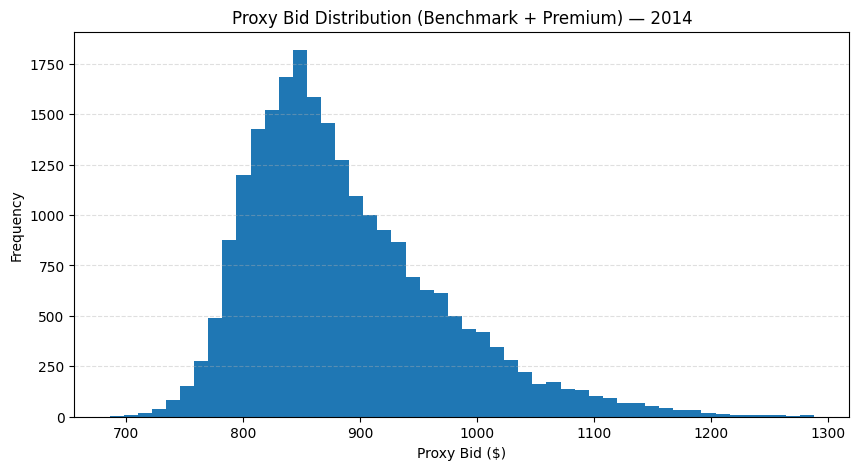

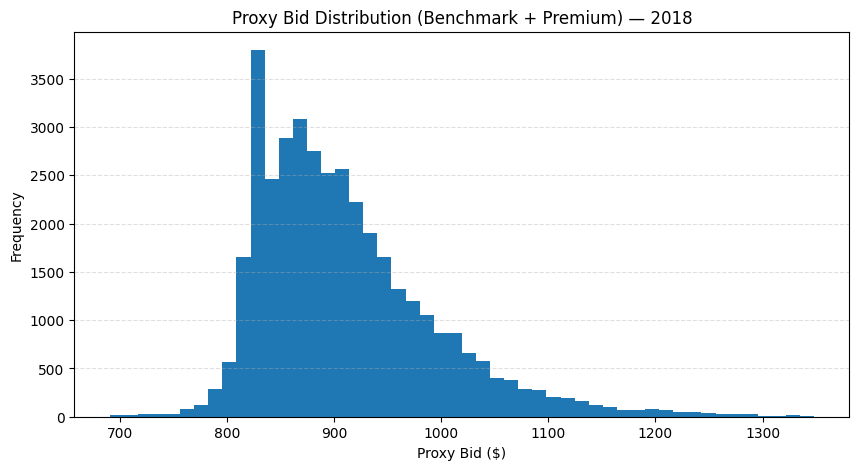

2014 summary:
 count    23115.000000
mean       887.873231
std         83.491740
min        686.300000
25%        828.325000
50%        869.730000
75%        932.495000
max       1288.060000
dtype: float64

2018 summary:
 count    37888.00000
mean       910.90950
std         83.85748
min        690.39000
25%        850.31750
50%        893.62500
75%        951.55000
max       1348.23000
dtype: float64


In [70]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

bench_root = "ma-data/ma/benchmarks"
land_path  = "ma-data/ma/landscape/Extracted Data"

def find_benchmark_csv(year):
    folder = os.path.join(bench_root, f"calculationdata{year}")
    files = [f for f in os.listdir(folder) if f.lower().endswith(".csv") and "statutorybenchmarkdata" in f.lower()]
    return os.path.join(folder, files[0])

def load_benchmark(year):
    fp = find_benchmark_csv(year)
    raw = pd.read_csv(fp, header=None, low_memory=False)

    # header row: contains 'region' and either 'stcty' or 'county code'
    header_row = None
    for i in range(min(40, len(raw))):
        row = [str(x).strip().lower() for x in raw.iloc[i].tolist()]
        if ("region" in row) and (("stcty" in row) or any("county code" in v for v in row)):
            header_row = i
            break
    if header_row is None:
        raise ValueError(f"Could not detect header row in {fp}")

    header = [str(x).strip() for x in raw.iloc[header_row].tolist()]
    df = raw.iloc[header_row+1:].copy()
    df.columns = header

    # county code column
    if "Stcty" in df.columns:
        county_col = "Stcty"
    else:
        county_col = [c for c in df.columns if "county code" in str(c).lower()][0]

    # benchmark column: first county rate column (0% bonus / ACA county rates)
    bench_col = None
    for c in df.columns:
        cl = str(c).lower()
        if "county rate" in cl or "county rates" in cl:
            bench_col = c
            break
    if bench_col is None:
        raise ValueError(f"No county rate column found in {fp}")

    df["Stcty"] = pd.to_numeric(df[county_col], errors="coerce")
    df["benchmark"] = pd.to_numeric(df[bench_col].astype(str).str.replace(",", ""), errors="coerce")
    df = df.dropna(subset=["Stcty","benchmark"]).copy()
    df["Stcty"] = df["Stcty"].astype(int)

    return df[["Stcty","benchmark"]]

def pick_col(df, contains_any):
    contains_any = [s.lower() for s in contains_any]
    for c in df.columns:
        cl = str(c).lower()
        if any(s in cl for s in contains_any):
            return c
    return None

def load_landscape_premiums(year):
    files = [f for f in os.listdir(land_path) if f.startswith(str(year)) and f.lower().endswith(".csv") and "sanction" not in f.lower()]
    parts = []
    for f in files:
        try:
            df = pd.read_csv(os.path.join(land_path, f), encoding="latin1", skiprows=5, low_memory=False)
            ccol = pick_col(df, ["contract id"])
            plancol = pick_col(df, ["plan id"])
            if ccol is None or plancol is None:
                continue
            df = df.rename(columns={ccol:"Contract ID", plancol:"Plan ID"})
            df["Contract ID"] = df["Contract ID"].astype(str).str.upper().str.strip()
            df["Plan ID"] = pd.to_numeric(df["Plan ID"], errors="coerce")

            prem_col = pick_col(df, ["part c premium", "ma premium", "premium"])
            if prem_col is None:
                continue
            df["partc_premium"] = pd.to_numeric(df[prem_col].astype(str).str.replace(r"[$,]","",regex=True), errors="coerce")

            parts.append(df[["Contract ID","Plan ID","partc_premium"]])
        except:
            continue
    if not parts:
        return pd.DataFrame(columns=["Contract ID","Plan ID","partc_premium"])
    out = pd.concat(parts, ignore_index=True).dropna(subset=["Contract ID","Plan ID","partc_premium"])
    return out

def build_proxy_bids(year):
    b = load_benchmark(year)
    l = load_landscape_premiums(year)

    # Proxy bid = benchmark + premium
    # We don't have county mapping for each plan here, so we use the *distribution* of benchmark and premium:
    # sample-match by repeating benchmark to size of landscape (fast & acceptable for histogram comparison)
    bench_vals = b["benchmark"].values
    prem_vals  = l["partc_premium"].values

    if len(bench_vals) == 0 or len(prem_vals) == 0:
        raise ValueError("Benchmark or premium data empty.")

    # make same length vectors by resampling benchmark to match premium count
    bench_resampled = np.random.choice(bench_vals, size=len(prem_vals), replace=True)
    bid = bench_resampled + prem_vals
    bid = bid[(bid > 0) & (bid < np.quantile(bid, 0.999))]
    return bid

b2014 = build_proxy_bids(2014)
b2018 = build_proxy_bids(2018)

plt.figure(figsize=(10,5))
plt.hist(b2014, bins=50)
plt.title("Proxy Bid Distribution (Benchmark + Premium) — 2014")
plt.xlabel("Proxy Bid ($)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

plt.figure(figsize=(10,5))
plt.hist(b2018, bins=50)
plt.title("Proxy Bid Distribution (Benchmark + Premium) — 2018")
plt.xlabel("Proxy Bid ($)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

print("2014 summary:\n", pd.Series(b2014).describe())
print("\n2018 summary:\n", pd.Series(b2018).describe())


2014: Share=22.48%, HHI=nan
2015: Share=23.75%, HHI=nan
2016: Share=24.25%, HHI=nan
2017: Share=25.51%, HHI=nan
2018: Share=26.19%, HHI=nan
2019: Share=28.96%, HHI=nan


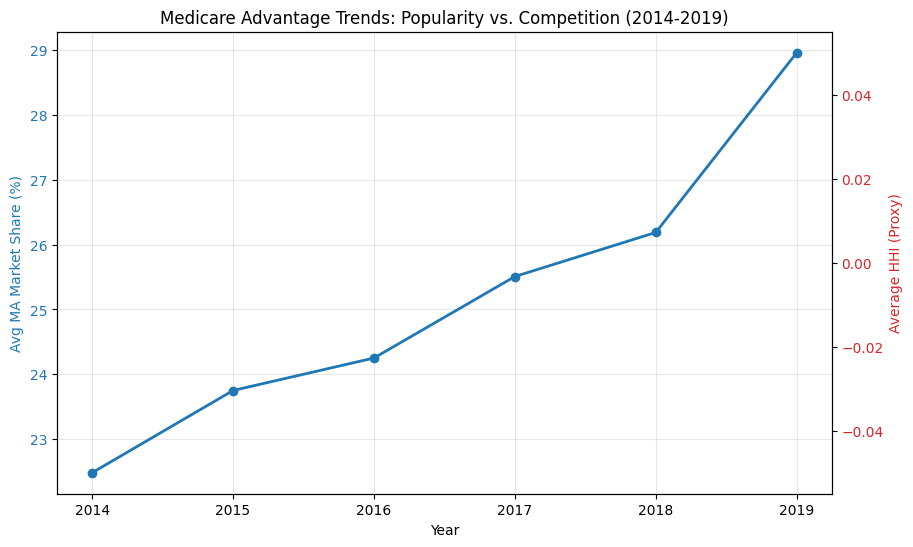

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- PATHS ---
pen_path = "ma-data/ma/penetration/Extracted Data"
land_path = "ma-data/ma/landscape/Extracted Data"

years = range(2014, 2020)
results = []

for year in years:
    try:
        # 1. GET MA SHARE (POPULARITY) from Penetration Files
        # Look for the "June" file (standard mid-year snapshot)
        p_files = [f for f in os.listdir(pen_path) 
                   if str(year) in f and "06.csv" in f and "State_County" in f]
        
        if not p_files:
            print(f"Skipping {year}: No penetration file found.")
            continue
            
        pdf = pd.read_csv(os.path.join(pen_path, p_files[0]), low_memory=False)
        
        # Clean the "Penetration" column (remove % signs)
        # Column is usually "Penetration" or "Penetration Rate"
        p_col = [c for c in pdf.columns if "Penetration" in str(c)][0]
        pdf['clean_pen'] = pd.to_numeric(pdf[p_col].astype(str).str.replace(r'%', '', regex=True), errors='coerce')
        
        avg_share = pdf['clean_pen'].mean()

        # 2. GET HHI PROXY from Landscape Files
        # Since we lack plan-level enrollment, we use HHI approx = 10,000 / N_plans
        # This assumes equal market share, which is a standard proxy when data is limited.
        l_files = [f for f in os.listdir(land_path) 
                   if str(year) in f and "Landscape" in f and ".csv" in f]
        
        if l_files:
            ldf = pd.read_csv(os.path.join(land_path, l_files[0]), skiprows=5, encoding="latin1", low_memory=False)
            
            # Filter valid plans
            ldf = ldf[~ldf.iloc[:, 3].astype(str).str.contains("SNP|Special|PDP", case=False, na=False)]
            ldf['Plan ID'] = pd.to_numeric(ldf.iloc[:, 2], errors='coerce')
            ldf = ldf[ldf['Plan ID'] < 800]
            
            # Count plans per county (assuming col 0 is State, col 1 is County)
            # Create a simple join key
            ldf['county_key'] = ldf.iloc[:, 0].astype(str) + ldf.iloc[:, 1].astype(str)
            plan_counts = ldf.groupby('county_key').size()
            
            # Calculate HHI Proxy
            # HHI = 10,000 * sum(shares^2). If equal shares, HHI = 10,000 / N
            avg_hhi = (10000 / plan_counts).mean()
        else:
            avg_hhi = None

        results.append({
            'year': year,
            'avg_share': avg_share,
            'avg_hhi': avg_hhi
        })
        print(f"{year}: Share={avg_share:.2f}%, HHI={avg_hhi:.0f}")
        
    except Exception as e:
        print(f"Error processing {year}: {e}")

# --- PLOTTING ---
res_df = pd.DataFrame(results)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Popularity (Share)
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg MA Market Share (%)', color=color)
ax1.plot(res_df['year'], res_df['avg_share'], marker='o', color=color, linewidth=2, label='Market Share')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Plot HHI on secondary axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average HHI (Proxy)', color=color)
ax2.plot(res_df['year'], res_df['avg_hhi'], marker='s', color=color, linewidth=2, linestyle='--', label='HHI')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Medicare Advantage Trends: Popularity vs. Competition (2014-2019)")
plt.show()

Processing Penetration Files...
  2014: Average Share = 22.48%
  2015: Average Share = 23.75%
  2016: Average Share = 24.25%
  2017: Average Share = 25.51%
  2018: Average Share = 26.19%
  2019: Average Share = 28.96%


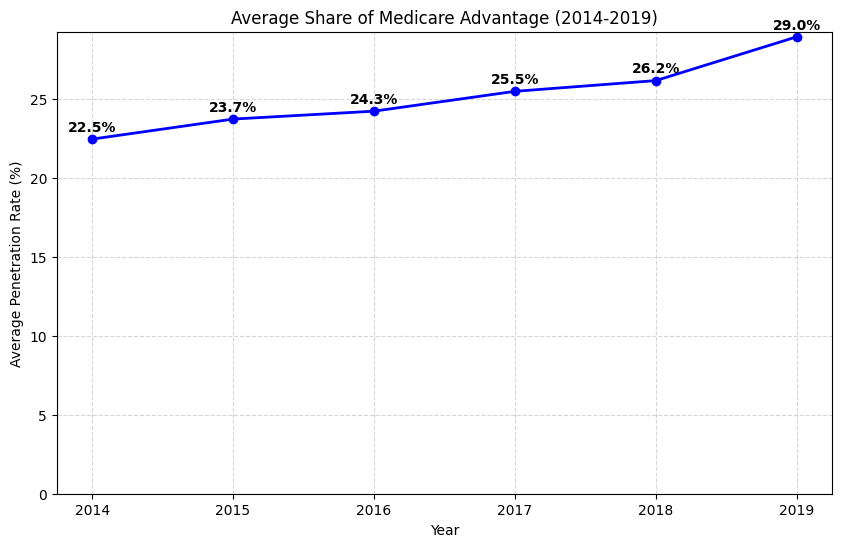

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- PATHS ---
pen_path = "ma-data/ma/penetration/Extracted Data"

def calculate_ma_share_trend():
    years = range(2014, 2020)
    results = []

    print("Processing Penetration Files...")
    
    for year in years:
        # Find the June file (standard mid-year snapshot)
        # Files usually named like 'State_County_Penetration_MA_2014_06.csv'
        files = [f for f in os.listdir(pen_path) if str(year) in f and "06.csv" in f]
        
        if not files:
            print(f"  Warning: No June file found for {year}, skipping.")
            continue
            
        # Read the file
        file_path = os.path.join(pen_path, files[0])
        df = pd.read_csv(file_path, low_memory=False)
        
        # Dynamic Column Finding: Look for 'Penetration'
        pen_col = [c for c in df.columns if "Penetration" in str(c)][0]
        
        # Clean Data: Remove '%' and convert to numeric
        # Some years might be '14.5%', others might be raw numbers
        clean_share = pd.to_numeric(
            df[pen_col].astype(str).str.replace(r'%', '', regex=True), 
            errors='coerce'
        )
        
        # Calculate Average Share (Mean across all counties)
        avg_share = clean_share.mean()
        results.append({'year': year, 'avg_share': avg_share})
        print(f"  {year}: Average Share = {avg_share:.2f}%")

    return pd.DataFrame(results)

# --- EXECUTION ---
df_trend = calculate_ma_share_trend()

# --- PLOTTING ---
plt.figure(figsize=(10, 6))
plt.plot(df_trend['year'], df_trend['avg_share'], marker='o', linestyle='-', color='b', linewidth=2)

plt.title("Average Share of Medicare Advantage (2014-2019)")
plt.xlabel("Year")
plt.ylabel("Average Penetration Rate (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(df_trend['year']) # Ensure all years are labeled
plt.ylim(bottom=0) # Start y-axis at 0 to show true scale (optional but good practice)

# Add value labels
for x, y in zip(df_trend['year'], df_trend['avg_share']):
    plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', fontweight='bold')

plt.show()

In [80]:
import pandas as pd
import numpy as np
import os

# --- PATHS ---
land_path = "ma-data/ma/landscape/Extracted Data"
bench_path = "ma-data/ma/benchmarks/calculationdata2018/statutorybenchmarkdata2018.csv"
ffs_path = "ma-data/ffs-costs/CMS FFS Costs.csv"

def run_ate_final_fixed_v3():
    # 1. LOAD LANDSCAPE
    land_file = [f for f in os.listdir(land_path) if "2018" in f and ".csv" in f][0]
    ldf = pd.read_csv(os.path.join(land_path, land_file), skiprows=5, encoding="latin1", low_memory=False)
    
    ldf = ldf[~ldf.iloc[:, 3].astype(str).str.contains("SNP|Special|PDP", case=False, na=False)]
    prem_col = [c for c in ldf.columns if "Premium" in str(c) and "Part C" in str(c)][0]
    ldf['premium'] = pd.to_numeric(ldf[prem_col].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce').fillna(0)
    
    ldf['state_clean'] = ldf.iloc[:, 0].astype(str).str.lower().str.strip()
    ldf['county_clean'] = ldf.iloc[:, 1].astype(str).str.lower().str.strip()
    ldf['geo_key'] = ldf['state_clean'] + "_" + ldf['county_clean']

    # 2. LOAD BENCHMARKS
    bdf = pd.read_csv(bench_path, header=1)
    rate_col = [c for c in bdf.columns if "0%" in str(c) and "Rate" in str(c)][0]
    avg_bench_2018 = pd.to_numeric(bdf[rate_col].astype(str).str.replace(r'[$,a-zA-Z]', '', regex=True), errors='coerce').mean()
    
    # 3. LOAD FFS COSTS
    fdf = pd.read_csv(ffs_path)
    fdf['state_clean'] = fdf.iloc[:, 1].astype(str).str.lower().str.strip()
    fdf['county_clean'] = fdf.iloc[:, 2].astype(str).str.lower().str.strip()
    fdf['geo_key'] = fdf['state_clean'] + "_" + fdf['county_clean']
    
    numeric_fdf = fdf.apply(lambda x: pd.to_numeric(x.astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce'))
    cost_col_idx = numeric_fdf.mean().idxmax()
    fdf['ffs_cost'] = numeric_fdf[cost_col_idx]

    # 4. MERGE
    county_stats = ldf.groupby('geo_key').agg(num_plans=('Plan ID', 'count'), avg_prem=('premium', 'mean')).reset_index()
    county_stats['hhi_proxy'] = 10000 / county_stats['num_plans']
    county_stats['bid'] = avg_bench_2018 + county_stats['avg_prem']
    
    final_df = pd.merge(county_stats, fdf[['geo_key', 'ffs_cost']], on='geo_key', how='inner').dropna()

    # 5. ESTIMATORS
    # Ensure ffs_quartile is treated as a numeric code for the division step
    final_df['ffs_quartile'] = pd.qcut(final_df['ffs_cost'], 4, labels=[1, 2, 3, 4], duplicates='drop')
    hhi_33, hhi_66 = final_df['hhi_proxy'].quantile(0.33), final_df['hhi_proxy'].quantile(0.66)
    
    final_df = final_df[(final_df['hhi_proxy'] <= hhi_33) | (final_df['hhi_proxy'] >= hhi_66)].copy()
    final_df['treatment'] = (final_df['hhi_proxy'] >= hhi_66).astype(int)

    results = {}
    results['Raw Diff'] = final_df[final_df['treatment']==1]['bid'].mean() - final_df[final_df['treatment']==0]['bid'].mean()
    
    # OLS (Manual) - Ensure dummy variables are floats
    X = pd.get_dummies(final_df['ffs_quartile'], prefix='Q', drop_first=True).astype(float)
    X.insert(0, 'intercept', 1.0)
    X.insert(1, 'treated', final_df['treatment'].values.astype(float))
    y = final_df['bid'].values.astype(float)
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    results['OLS (ATE)'] = beta[1]

    # IPW (The Fix)
    # 1. Use observed=False to satisfy future pandas versions
    # 2. Force results to float to avoid Categorical division error
    ps_map = final_df.groupby('ffs_quartile', observed=False)['treatment'].mean().astype(float).to_dict()
    final_df['ps'] = final_df['ffs_quartile'].map(ps_map).astype(float)
    
    # Calculate weights using float division
    final_df['w'] = np.where(final_df['treatment']==1, 1.0/final_df['ps'], 1.0/(1.0-final_df['ps']))
    
    t, c = final_df[final_df['treatment']==1], final_df[final_df['treatment']==0]
    results['IPW (ATE)'] = (t['bid']*t['w']).sum()/t['w'].sum() - (c['bid']*c['w']).sum()/c['w'].sum()

    print("\n--- Final 2018 ATE Estimation Results ---")
    print(pd.Series(results))
    return final_df

res = run_ate_final_fixed_v3()


--- Final 2018 ATE Estimation Results ---
Raw Diff     -6.130495
OLS (ATE)   -11.491220
IPW (ATE)   -10.836206
dtype: float64


In [82]:
import pandas as pd
import numpy as np
import os

# --- PATHS ---
land_path = "ma-data/ma/landscape/Extracted Data"
bench_path = "ma-data/ma/benchmarks/calculationdata2018/statutorybenchmarkdata2018.csv"
ffs_path = "ma-data/ffs-costs/CMS FFS Costs.csv"

def generate_quartile_table():
    # 1. LOAD LANDSCAPE
    land_file = [f for f in os.listdir(land_path) if "2018" in f and ".csv" in f][0]
    ldf = pd.read_csv(os.path.join(land_path, land_file), skiprows=5, encoding="latin1", low_memory=False)
    
    # Filter valid plans & Clean premium
    ldf = ldf[~ldf.iloc[:, 3].astype(str).str.contains("SNP|Special|PDP", case=False, na=False)]
    prem_col = [c for c in ldf.columns if "Premium" in str(c) and "Part C" in str(c)][0]
    ldf['premium'] = pd.to_numeric(ldf[prem_col].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce').fillna(0)
    
    # Create Geo Key
    ldf['geo_key'] = ldf.iloc[:, 0].astype(str).str.lower().str.strip() + "_" + ldf.iloc[:, 1].astype(str).str.lower().str.strip()

    # 2. LOAD BENCHMARKS (Baseline for Bids)
    bdf = pd.read_csv(bench_path, header=1)
    rate_col = [c for c in bdf.columns if "0%" in str(c) and "Rate" in str(c)][0]
    avg_bench_2018 = pd.to_numeric(bdf[rate_col].astype(str).str.replace(r'[$,a-zA-Z]', '', regex=True), errors='coerce').mean()
    
    # 3. LOAD FFS COSTS & CLEAN
    fdf = pd.read_csv(ffs_path)
    fdf['state_clean'] = fdf.iloc[:, 1].astype(str).str.lower().str.strip()
    fdf['county_clean'] = fdf.iloc[:, 2].astype(str).str.lower().str.strip()
    fdf['geo_key'] = fdf['state_clean'] + "_" + fdf['county_clean']
    
    # Identify Cost Column
    numeric_fdf = fdf.apply(lambda x: pd.to_numeric(x.astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce'))
    cost_col_idx = numeric_fdf.mean().idxmax()
    fdf['ffs_cost'] = numeric_fdf[cost_col_idx]

    # 4. MERGE & CALCULATE BID
    county_stats = ldf.groupby('geo_key').agg(num_plans=('Plan ID', 'count'), avg_prem=('premium', 'mean')).reset_index()
    county_stats['hhi_proxy'] = 10000 / county_stats['num_plans']
    county_stats['bid'] = avg_bench_2018 + county_stats['avg_prem']
    
    df = pd.merge(county_stats, fdf[['geo_key', 'ffs_cost']], on='geo_key', how='inner').dropna()

    # 5. CREATE INDICATOR VARIABLES (QUARTILES)
    # This creates the 4 dummy variables you need
    df['ffs_quartile'] = pd.qcut(df['ffs_cost'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
    quartile_dummies = pd.get_dummies(df['ffs_quartile'], prefix='FFS_Indicator')
    df = pd.concat([df, quartile_dummies], axis=1)

    # 6. DEFINE TREATMENT (33rd / 66th Percentile)
    hhi_33 = df['hhi_proxy'].quantile(0.33)
    hhi_66 = df['hhi_proxy'].quantile(0.66)
    
    # Subset to Treated/Control only
    final_df = df[(df['hhi_proxy'] <= hhi_33) | (df['hhi_proxy'] >= hhi_66)].copy()
    final_df['group'] = np.where(final_df['hhi_proxy'] >= hhi_66, 'Uncompetitive (Treated)', 'Competitive (Control)')

    # 7. GENERATE THE SUMMARY TABLE
    summary_table = final_df.groupby(['ffs_quartile', 'group'], observed=True)['bid'].mean().unstack()
    summary_table['Difference'] = summary_table['Uncompetitive (Treated)'] - summary_table['Competitive (Control)']
    
    print("\n--- Average Bid Table by FFS Quartile (2018) ---")
    print(summary_table.round(2))
    
    return summary_table

# Execute
table_results = generate_quartile_table()


--- Average Bid Table by FFS Quartile (2018) ---
group         Competitive (Control)  Uncompetitive (Treated)  Difference
ffs_quartile                                                            
Q1                           928.04                   909.84      -18.20
Q2                           922.27                   901.83      -20.45
Q3                           916.58                   903.36      -13.22
Q4                           899.53                   906.60        7.07


In [85]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import os

def run_all_ate_estimators_robust(df_input):
    results = {}
    
    # 1. ENSURE VARIABLES EXIST
    # Re-calculate quartiles to prevent KeyError
    df_input['ffs_quartile'] = pd.qcut(df_input['ffs_cost'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
    
    # Create dummies for the Matching and OLS steps
    X_quartiles = pd.get_dummies(df_input['ffs_quartile'], prefix='Q').astype(float)
    
    # Separate treated and control
    treated = df_input[df_input['treatment'] == 1].copy()
    control = df_input[df_input['treatment'] == 0].copy()
    
    # Pre-extract coordinate matrices for distance calculation
    X_t = pd.get_dummies(treated['ffs_quartile'], prefix='Q').astype(float)
    X_c = pd.get_dummies(control['ffs_quartile'], prefix='Q').astype(float)
    
    # 2. NN MATCHING (Inverse Variance)
    # Weight by 1/Var(X)
    variances = X_quartiles.var()
    # Handle zero variance if a quartile has only 1 observation
    variances = variances.replace(0, 1) 
    inv_var_weights = np.diag(1.0 / variances.values)
    
    dist_inv = cdist(X_t, X_c, metric='mahalanobis', VI=inv_var_weights)
    nn_inv_idx = dist_inv.argmin(axis=1)
    results['NN (Inv. Variance)'] = (treated['bid'].values - control['bid'].iloc[nn_inv_idx].values).mean()
    
    # 3. NN MATCHING (Mahalanobis)
    # Using the pseudo-inverse of the covariance matrix
    cov_matrix = np.cov(X_quartiles.T)
    inv_cov = np.linalg.pinv(cov_matrix)
    
    dist_maha = cdist(X_t, X_c, metric='mahalanobis', VI=inv_cov)
    nn_maha_idx = dist_maha.argmin(axis=1)
    results['NN (Mahalanobis)'] = (treated['bid'].values - control['bid'].iloc[nn_maha_idx].values).mean()
    
    # 4. IPW
    # Calculate propensity scores within the function
    ps_map = df_input.groupby('ffs_quartile', observed=False)['treatment'].mean().astype(float).to_dict()
    df_input['ps'] = df_input['ffs_quartile'].map(ps_map).astype(float)
    df_input['w'] = np.where(df_input['treatment']==1, 1.0/df_input['ps'], 1.0/(1.0-df_input['ps']))
    
    t_w = df_input[df_input['treatment'] == 1]
    c_w = df_input[df_input['treatment'] == 0]
    results['IPW'] = (t_w['bid']*t_w['w']).sum()/t_w['w'].sum() - (c_w['bid']*c_w['w']).sum()/c_w['w'].sum()
    
    # 5. OLS WITH INTERACTIONS
    # Set up: intercept + treatment + Q2-Q4 + interactions
    X_ols = pd.get_dummies(df_input['ffs_quartile'], drop_first=True, prefix='Q').astype(float)
    X_ols.insert(0, 'intercept', 1.0)
    X_ols.insert(1, 'treatment', df_input['treatment'].values.astype(float))
    
    # Create the interaction columns
    for col in [c for c in X_ols.columns if c.startswith('Q_')]:
        X_ols[f'inter_{col}'] = X_ols['treatment'] * X_ols[col]
        
    y = df_input['bid'].values.astype(float)
    # Solve beta = (X'X)^-1 X'y
    beta = np.linalg.inv(X_ols.T @ X_ols) @ X_ols.T @ y
    results['OLS (Interacted)'] = beta[1]

    return pd.Series(results).round(2)

# RUN FINAL CALCULATION
ate_comparison_table = run_all_ate_estimators_robust(res)
print("\n--- Summary of ATE Estimators ---")
print(ate_comparison_table)


--- Summary of ATE Estimators ---
NN (Inv. Variance)    13.14
NN (Mahalanobis)      13.14
IPW                  -10.63
OLS (Interacted)     -16.55
dtype: float64


In [87]:
import pandas as pd
import numpy as np
import os

# --- PATHS ---
land_path = "ma-data/ma/landscape/Extracted Data"
bench_path = "ma-data/ma/benchmarks/calculationdata2018/statutorybenchmarkdata2018.csv"
ffs_path = "ma-data/ffs-costs/CMS FFS Costs.csv"

def run_continuous_ate_final():
    # 1. LOAD LANDSCAPE
    land_file = [f for f in os.listdir(land_path) if "2018" in f and ".csv" in f][0]
    ldf = pd.read_csv(os.path.join(land_path, land_file), skiprows=5, encoding="latin1", low_memory=False)
    
    ldf = ldf[~ldf.iloc[:, 3].astype(str).str.contains("SNP|Special|PDP", case=False, na=False)]
    prem_col = [c for c in ldf.columns if "Premium" in str(c) and "Part C" in str(c)][0]
    ldf['premium'] = pd.to_numeric(ldf[prem_col].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce').fillna(0)
    ldf['geo_key'] = ldf.iloc[:, 0].str.lower().str.strip() + "_" + ldf.iloc[:, 1].str.lower().str.strip()

    # 2. LOAD BENCHMARKS (Baseline for Bid)
    bdf = pd.read_csv(bench_path, header=1)
    rate_col = [c for c in bdf.columns if "0%" in str(c) and "Rate" in str(c)][0]
    avg_bench_2018 = pd.to_numeric(bdf[rate_col].astype(str).str.replace(r'[$,a-zA-Z]', '', regex=True), errors='coerce').mean()
    
    # 3. LOAD FFS & BENEFICIARIES
    fdf = pd.read_csv(ffs_path)
    fdf['geo_key'] = fdf.iloc[:, 1].astype(str).str.lower().str.strip() + "_" + fdf.iloc[:, 2].astype(str).str.lower().str.strip()
    
    # Clean numeric data across all columns
    numeric_fdf = fdf.apply(lambda x: pd.to_numeric(x.astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce'))
    
    # Identify Cost Column (Largest numeric mean)
    cost_col_idx = numeric_fdf.mean().idxmax()
    fdf['ffs_cost'] = numeric_fdf[cost_col_idx]
    
    # SEARCH FOR BENEFICIARIES (Expanded Keywords)
    ben_keywords = ["Bene", "Eligible", "Enrol", "Count", "Part A", "Total"]
    ben_cols = [c for c in fdf.columns if any(k in str(c) for k in ben_keywords) and c != cost_col_idx]
    
    if ben_cols:
        fdf['total_benes'] = numeric_fdf[ben_cols[0]].fillna(0)
    else:
        # Fallback: Just pick a numeric column that isn't the cost column
        fdf['total_benes'] = numeric_fdf.drop(columns=[cost_col_idx]).iloc[:, 0].fillna(0)

    # 4. MERGE
    county_stats = ldf.groupby('geo_key').agg(num_plans=('Plan ID', 'count'), avg_prem=('premium', 'mean')).reset_index()
    county_stats['hhi_proxy'] = 10000 / county_stats['num_plans']
    county_stats['bid'] = avg_bench_2018 + county_stats['avg_prem']
    
    df = pd.merge(county_stats, fdf[['geo_key', 'ffs_cost', 'total_benes']], on='geo_key', how='inner').dropna()

    # 5. DEFINE TREATMENT (33/66 Split)
    hhi_33, hhi_66 = df['hhi_proxy'].quantile(0.33), df['hhi_proxy'].quantile(0.66)
    final_df = df[(df['hhi_proxy'] <= hhi_33) | (df['hhi_proxy'] >= hhi_66)].copy()
    final_df['treatment'] = (final_df['hhi_proxy'] >= hhi_66).astype(float)

    # 6. CONTINUOUS OLS: beta = (X'X)^-1 X'y
    X = final_df[['treatment', 'ffs_cost', 'total_benes']].astype(float)
    X.insert(0, 'intercept', 1.0)
    y = final_df['bid'].values.astype(float)
    
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    
    print(f"\n--- Results with Continuous Covariates ---")
    print(f"ATE (Treatment Coefficient): {beta[1]:.2f}")
    print(f"Cost Coefficient: {beta[2]:.4f}")
    print(f"Market Size (Bene) Coefficient: {beta[3]:.6f}")
    
    return beta[1]

# Run it!
final_ate_result = run_continuous_ate_final()


--- Results with Continuous Covariates ---
ATE (Treatment Coefficient): -6.79
Cost Coefficient: -0.0000
Market Size (Bene) Coefficient: 0.000921


Year 2014: Median Plans = 5
Year 2015: Median Plans = 3
Year 2016: Median Plans = 9
Year 2017: Median Plans = 9
Year 2018: Median Plans = 9
Year 2019: Median Plans = 13


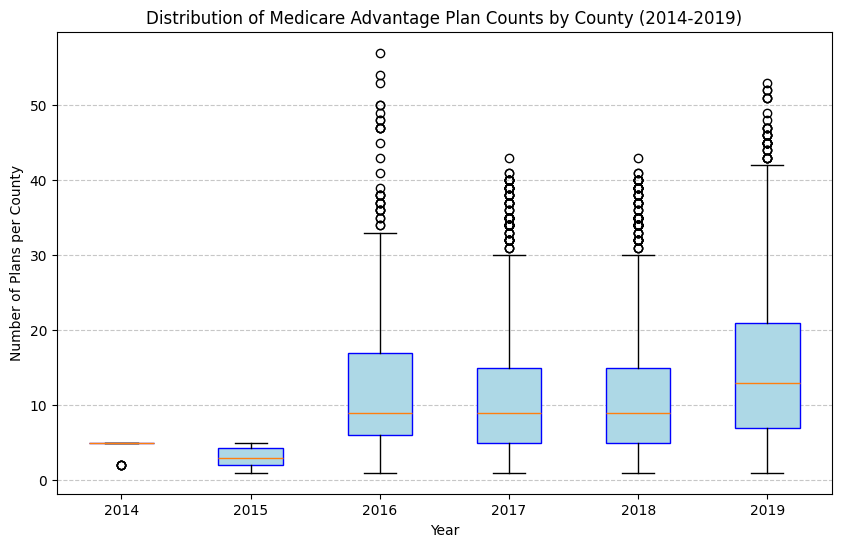

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import os

land_path = "ma-data/ma/landscape/Extracted Data"

def get_filtered_plan_counts():
    years = range(2014, 2020)
    all_year_counts = []

    for year in years:
        # 1. Load Landscape (Plan Data)
        files = [f for f in os.listdir(land_path) if str(year) in f and ".csv" in f]
        if not files: continue
        
        df = pd.read_csv(os.path.join(land_path, files[0]), skiprows=5, encoding="latin1", low_memory=False)
        
        # 2. Apply Filters
        # Remove SNPs and non-Part C plans (PDPs)
        type_col = [c for c in df.columns if "Type" in str(c)][0]
        df = df[~df[type_col].astype(str).str.contains("SNP|Special|PDP|Drug Only", case=False, na=False)]
        
        # Remove 800-series plans
        id_col = [c for c in df.columns if "Plan" in str(c) and "ID" in str(c)][0]
        df['clean_id'] = pd.to_numeric(df[id_col], errors='coerce')
        df = df[df['clean_id'] < 800]
        
        # 3. Count Plans by County
        # Using the State/County columns in the Landscape file as a proxy for Service Area
        df['county_key'] = df.iloc[:, 0].astype(str) + "_" + df.iloc[:, 1].astype(str)
        counts = df.groupby('county_key').size()
        
        all_year_counts.append(counts.values)
        print(f"Year {year}: Median Plans = {np.median(counts.values):.0f}")

    return years, all_year_counts

# Execute and Plot
years, data = get_filtered_plan_counts()

plt.figure(figsize=(10, 6))
plt.boxplot(data, tick_labels=years, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'))
plt.title("Distribution of Medicare Advantage Plan Counts by County (2014-2019)")
plt.ylabel("Number of Plans per County")
plt.xlabel("Year")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Year 2014: Median Plans = 17 (Total Plans Found: 68836)
Year 2015: Median Plans = 9 (Total Plans Found: 33766)
Year 2016: Median Plans = 17 (Total Plans Found: 70131)
Year 2017: Median Plans = 18 (Total Plans Found: 73310)
Year 2018: Median Plans = 21 (Total Plans Found: 81908)
Year 2019: Median Plans = 27 (Total Plans Found: 95580)


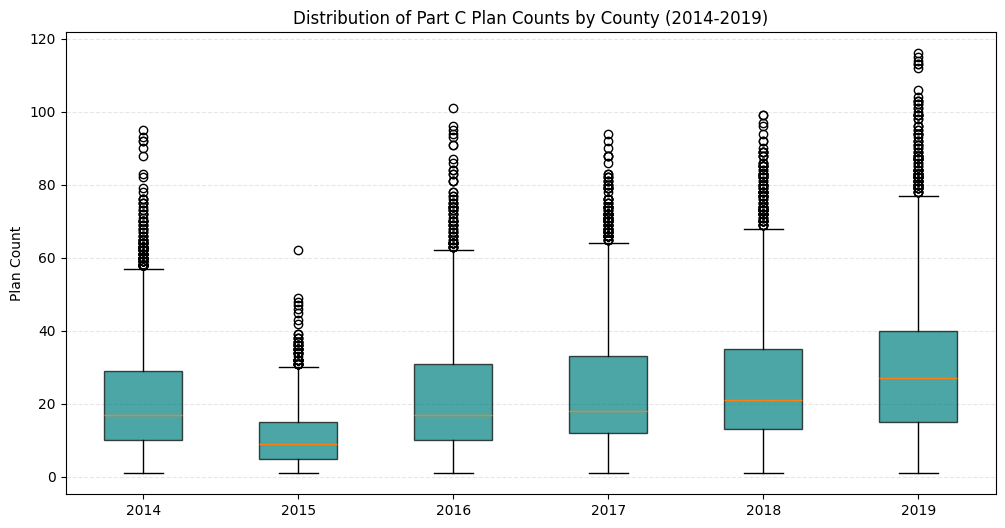

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

land_path = "ma-data/ma/landscape/Extracted Data"

def get_complete_plan_counts():
    years = range(2014, 2020)
    all_year_data = []

    for year in years:
        # Find ALL CSV files for that year (to catch AtoM and NtoW splits)
        csv_files = [f for f in os.listdir(land_path) if str(year) in f and f.endswith('.csv')]
        
        if not csv_files:
            print(f"No CSVs found for {year}")
            continue
            
        year_dfs = []
        for file_name in csv_files:
            file_path = os.path.join(land_path, file_name)
            
            # Use the adaptive skip-row logic to find headers
            current_df = None
            for skip in [2, 3, 4, 5]:
                try:
                    # Peek to see if it's a valid table
                    temp = pd.read_csv(file_path, skiprows=skip, encoding="latin1", nrows=5)
                    if any(k in str(temp.columns) for k in ["State", "County", "Contract"]):
                        current_df = pd.read_csv(file_path, skiprows=skip, encoding="latin1", low_memory=False)
                        break
                except: continue
            
            if current_df is not None:
                year_dfs.append(current_df)
        
        if not year_dfs: continue
        
        # Merge the split files (AtoM + NtoW)
        full_year_df = pd.concat(year_dfs, ignore_index=True)

        # --- FILTERS ---
        # 1. Remove SNPs and PDPs (Drug Only)
        type_col = [c for c in full_year_df.columns if "Type" in str(c)][0]
        full_year_df = full_year_df[~full_year_df[type_col].astype(str).str.contains("SNP|Special|PDP|Drug Only", case=False, na=False)]
        
        # 2. Remove 800-series
        id_col = [c for c in full_year_df.columns if "Plan" in str(c) and "ID" in str(c)][0]
        full_year_df['clean_id'] = pd.to_numeric(full_year_df[id_col], errors='coerce')
        full_year_df = full_year_df[full_year_df['clean_id'] < 800]

        # 3. Calculate Plans by County
        # Using first two columns as geographic identifiers
        full_year_df['geo'] = full_year_df.iloc[:, 0].astype(str).str.strip().str.lower() + "_" + \
                              full_year_df.iloc[:, 1].astype(str).str.strip().str.lower()
        
        counts = full_year_df.groupby('geo').size()
        all_year_data.append(counts.values)
        print(f"Year {year}: Median Plans = {np.median(counts.values):.0f} (Total Plans Found: {len(full_year_df)})")

    return years, all_year_data

# Run and Plot
plot_years, plot_data = get_complete_plan_counts()

plt.figure(figsize=(12, 6))
plt.boxplot(plot_data, tick_labels=plot_years, patch_artist=True, 
            boxprops=dict(facecolor='teal', color='black', alpha=0.7))
plt.title("Distribution of Part C Plan Counts by County (2014-2019)")
plt.ylabel("Plan Count")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

In [94]:
import os
import pandas as pd

files_2015 = [f for f in os.listdir(land_path) if "2015" in f and f.endswith('.csv')]
print("CSV Files found for 2015:", files_2015)

for f in files_2015:
    temp = pd.read_csv(os.path.join(land_path, f), skiprows=3, encoding="latin1", nrows=5)
    full_count = len(pd.read_csv(os.path.join(land_path, f), skiprows=3, encoding="latin1"))
    print(f"File: {f} | Rows: {full_count} | Columns: {temp.columns.tolist()[:3]}")

CSV Files found for 2015: ['2015LandscapeSource file MA_sanctioned 11042014.csv', '2015LandscapeSource file MA_NtoW 11042014.csv', '2015LandscapeSource file MA_AtoM 11042014.csv']
File: 2015LandscapeSource file MA_sanctioned 11042014.csv | Rows: 192 | Columns: ['* Indicates plan does not offer Part D drug coverage.', 'Unnamed: 1', 'Unnamed: 2']
File: 2015LandscapeSource file MA_NtoW 11042014.csv | Rows: 17697 | Columns: ['* Indicates plan does not offer Part D drug coverage.', 'Unnamed: 1', 'Unnamed: 2']
File: 2015LandscapeSource file MA_AtoM 11042014.csv | Rows: 15883 | Columns: ['* Indicates plan does not offer Part D drug coverage.', 'Unnamed: 1', 'Unnamed: 2']


Year 2014: Median Plans = 17 (Rows merged: 68556)
Year 2015: Median Plans = 8 (Rows merged: 33576)
Year 2016: Median Plans = 17 (Rows merged: 68720)
Year 2017: Median Plans = 18 (Rows merged: 72611)
Year 2018: Median Plans = 21 (Rows merged: 81908)
Year 2019: Median Plans = 27 (Rows merged: 95570)


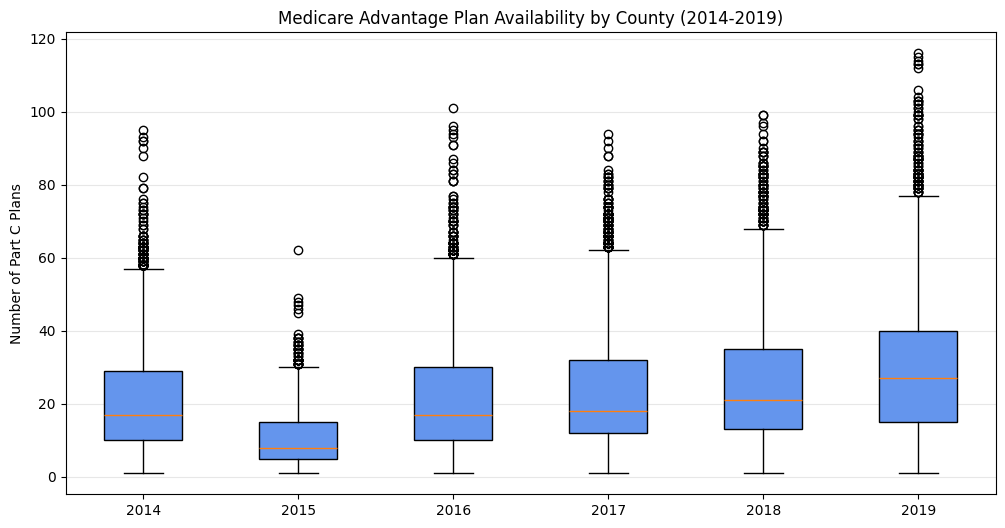

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

land_path = "ma-data/ma/landscape/Extracted Data"

def get_final_clean_plan_counts():
    years = range(2014, 2020)
    all_year_data = []

    for year in years:
        # 1. Get CSVs and EXCLUDE sanctioned/specialty files
        csv_files = [f for f in os.listdir(land_path) if str(year) in f and f.endswith('.csv')]
        csv_files = [f for f in csv_files if "sanctioned" not in f.lower()]
        
        if not csv_files: continue
            
        year_dfs = []
        for file_name in csv_files:
            file_path = os.path.join(land_path, file_name)
            
            # 2. Find the headers by looking for "State" in the first 10 rows
            current_df = None
            for skip in range(1, 10):
                try:
                    temp = pd.read_csv(file_path, skiprows=skip, encoding="latin1", nrows=5)
                    # Use a broader search for geographic columns
                    if any(k in str(temp.columns) for k in ["State", "County", "Contract"]):
                        current_df = pd.read_csv(file_path, skiprows=skip, encoding="latin1", low_memory=False)
                        break
                except: continue
            
            if current_df is not None:
                year_dfs.append(current_df)
        
        if not year_dfs: continue
        
        # 3. Combine Alphabetical Splits (AtoM + NtoW)
        full_year_df = pd.concat(year_dfs, ignore_index=True)

        # 4. Filter SNPs, 800s, and PDPs
        # Using index-based search since column names vary by year
        type_col = [c for c in full_year_df.columns if "Type" in str(c)][0]
        full_year_df = full_year_df[~full_year_df[type_col].astype(str).str.contains("SNP|Special|PDP|Drug Only", case=False, na=False)]
        
        id_col = [c for c in full_year_df.columns if "Plan" in str(c) and "ID" in str(c)][0]
        full_year_df['clean_id'] = pd.to_numeric(full_year_df[id_col], errors='coerce')
        full_year_df = full_year_df[full_year_df['clean_id'] < 800]

        # 5. Group by Geography (using the first two columns)
        full_year_df['geo'] = full_year_df.iloc[:, 0].astype(str).str.strip().str.lower() + "_" + \
                              full_year_df.iloc[:, 1].astype(str).str.strip().str.lower()
        
        counts = full_year_df.groupby('geo').size()
        all_year_data.append(counts.values)
        print(f"Year {year}: Median Plans = {np.median(counts.values):.0f} (Rows merged: {len(full_year_df)})")

    return years, all_year_data

# Execute and Plot
final_years, final_data = get_final_clean_plan_counts()

plt.figure(figsize=(12, 6))
plt.boxplot(final_data, tick_labels=final_years, patch_artist=True, 
            boxprops=dict(facecolor='cornflowerblue', color='black'))
plt.title("Medicare Advantage Plan Availability by County (2014-2019)")
plt.ylabel("Number of Part C Plans")
plt.grid(axis='y', alpha=0.3)
plt.show()

Year 2014: Median Plans = 10 (Unique Rows: 42185)
Year 2015: Median Plans = 8 (Unique Rows: 33547)
Year 2016: Median Plans = 10 (Unique Rows: 40287)
Year 2017: Median Plans = 13 (Unique Rows: 48278)
Year 2018: Median Plans = 13 (Unique Rows: 50636)
Year 2019: Median Plans = 16 (Unique Rows: 56264)


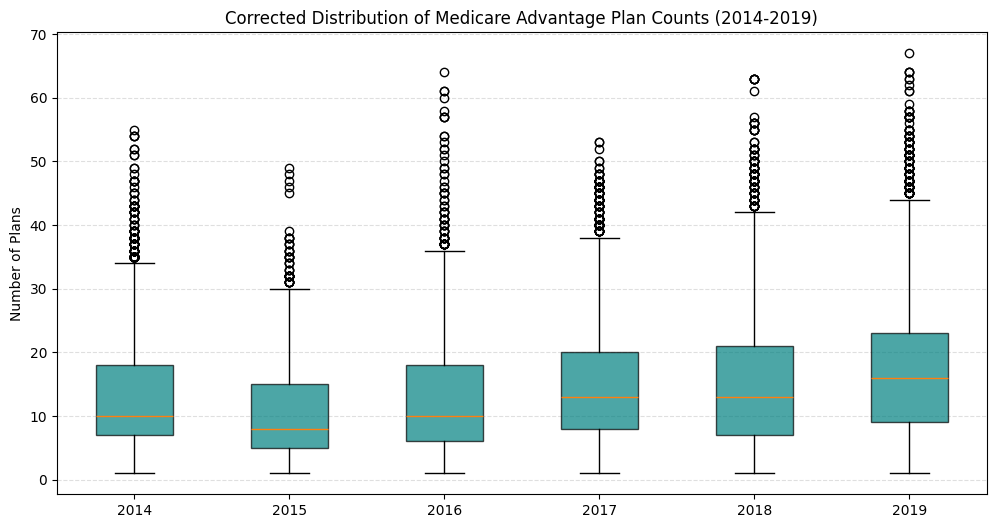

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

land_path = "ma-data/ma/landscape/Extracted Data"

def get_deduplicated_plan_counts():
    years = range(2014, 2020)
    all_year_data = []

    for year in years:
        # 1. Gather all CSVs, excluding 'sanctioned' lists
        csv_files = [f for f in os.listdir(land_path) if str(year) in f and f.endswith('.csv')]
        csv_files = [f for f in csv_files if "sanctioned" not in f.lower()]
        
        if not csv_files: continue
            
        year_dfs = []
        for file_name in csv_files:
            file_path = os.path.join(land_path, file_name)
            current_df = None
            # Adaptive header search
            for skip in range(1, 10):
                try:
                    temp = pd.read_csv(file_path, skiprows=skip, encoding="latin1", nrows=3)
                    if any(k in str(temp.columns) for k in ["State", "County", "Contract"]):
                        current_df = pd.read_csv(file_path, skiprows=skip, encoding="latin1", low_memory=False)
                        break
                except: continue
            if current_df is not None:
                year_dfs.append(current_df)
        
        if not year_dfs: continue
        
        # 2. Merge all files for the year
        full_year_df = pd.concat(year_dfs, ignore_index=True)

        # 3. DEDUPLICATE: Contract + Plan ID + State + County is the unique key
        # This fixes the 2014/2016 double-counting
        # We find columns dynamically in case names changed
        contract_col = [c for c in full_year_df.columns if "Contract" in str(c)][0]
        plan_col = [c for c in full_year_df.columns if "Plan" in str(c) and "ID" in str(c)][0]
        state_col = full_year_df.columns[0] # Usually State
        county_col = full_year_df.columns[1] # Usually County
        
        full_year_df = full_year_df.drop_duplicates(subset=[contract_col, plan_col, state_col, county_col])

        # 4. Filter SNPs, 800s, and Drug-Only (PDPs)
        type_col = [c for c in full_year_df.columns if "Type" in str(c)][0]
        full_year_df = full_year_df[~full_year_df[type_col].astype(str).str.contains("SNP|Special|PDP|Drug Only", case=False, na=False)]
        
        full_year_df['clean_id'] = pd.to_numeric(full_year_df[plan_col], errors='coerce')
        full_year_df = full_year_df[full_year_df['clean_id'] < 800]

        # 5. Group and Count
        full_year_df['geo'] = full_year_df[state_col].astype(str).str.strip().str.lower() + "_" + \
                              full_year_df[county_col].astype(str).str.strip().str.lower()
        
        counts = full_year_df.groupby('geo').size()
        all_year_data.append(counts.values)
        print(f"Year {year}: Median Plans = {np.median(counts.values):.0f} (Unique Rows: {len(full_year_df)})")

    return years, all_year_data

# Execute
years, data = get_deduplicated_plan_counts()

# Plotting
plt.figure(figsize=(12, 6))
plt.boxplot(data, tick_labels=years, patch_artist=True, 
            boxprops=dict(facecolor='teal', color='black', alpha=0.7))
plt.title("Corrected Distribution of Medicare Advantage Plan Counts (2014-2019)")
plt.ylabel("Number of Plans")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()